## Using neural networks to predict on Kryptonite-N dataset

In [72]:
import os
myseed = 180
os.environ['PYTHONHASHSEED'] = str(myseed)
os.environ["CUBLAS_WORKSPACE_CONFIG"]= ":4096:8"
os.environ["PYTORCH_CUDA_ALLOC_CONF"]= "expandable_segments:True"
print(os.getenv("CUBLAS_WORKSPACE_CONFIG"))
print(os.getenv("PYTORCH_CUDA_ALLOC_CONF"))

import numpy as np
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from itertools import product
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_gaussian_process
import time
import matplotlib.pyplot as plt
from codecarbon import EmissionsTracker


:4096:8
expandable_segments:True


In [ ]:
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Setting seeds for reproducibility

def set_seeds(myseed):

    random.seed(myseed)
    np.random.seed(myseed)
    torch.manual_seed(myseed)
    torch.cuda.manual_seed(myseed)
    torch.cuda.manual_seed_all(myseed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)


set_seeds(myseed)


2.5.1+cu118
Device: cuda


In [63]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, depth):
        super().__init__()
        # self.linear_layer_stack = nn.Sequential(
        #     nn.Linear(input_size, hidden_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size,hidden_size), 
        #     nn.ReLU(),
        #     nn.Linear(hidden_size,1), 
        # )



        modules = [torch.nn.Linear(input_size,hidden_size), torch.nn.LeakyReLU()]

        for i in range(depth-1):
            modules.append(torch.nn.Linear(hidden_size,hidden_size))
            modules.append(torch.nn.LeakyReLU())

        self.output_layer = torch.nn.Linear(hidden_size, 1)

        self.hidden_layer_stack = torch.nn.Sequential(
            *modules,
        )
        
        set_seeds(myseed)
        self._initialize_weights()  


    def _initialize_weights(self):
        for layer in self.hidden_layer_stack:
            if isinstance(layer, nn.Linear):
                torch.nn.init.kaiming_uniform_(layer.weight)
                torch.nn.init.zeros_(layer.bias)


    def forward(self, x):
        x = self.hidden_layer_stack(x)
        return self.output_layer(x)

#### Validation

In [ ]:
#  Function to validate model performance
def validate_nn(model, X_val, y_val):
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val.to(device))
        val_outputs = torch.round(torch.sigmoid(val_outputs)).cpu().numpy()
        accuracy = accuracy_score(y_val, val_outputs)
    return accuracy

In [ ]:




def train_nn(model, dataloader, criterion, optimizer, epochs, X_val, y_val):
    start= time.perf_counter()
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.unsqueeze(1).to(device)  # Move data to device
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.4f}')
        # Function
        # eoe_time = time.perf_counter()
        # if eoe_time-start > 150:
        #     return epoch+1
            
        
        
        if (epoch+1)%10 == 0:
            validation_acc = validate_nn(model,X_val, y_val)
            print(f"Validation Accuracy: {validation_acc}")

        # if epoch%10 == 0:
        #     validate_nn(model, )

    return epochs


        



In [66]:
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"
print('Device: {0}'.format(device))

# setting kryptonite dataset no.
n = 24

# Reading and normalising dataset features for efficient convergence
scaler = StandardScaler()

X = np.load('Datasets/kryptonite-%s-X.npy'%(n))
y = np.load('Datasets/kryptonite-%s-y.npy'%(n))

# print(f"X shape: {X.shape()}")
print(np.shape(X))

if n>18:
    X_add = np.load('Datasets/additional-kryptonite-%s-X.npy'%(n))
    print(np.shape(X_add))
    y_add = np.load('Datasets/additional-kryptonite-%s-y.npy'%(n))

    X=  np.concatenate((X,X_add),axis = 0)
    y=  np.concatenate((y,y_add),axis = 0)


print(np.shape(X))


# print((X[0]))

# # Shuffle and split the data
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=myseed)  # 60% training

# scaler.fit(X_train)
# scaler.transform(X_train)
# scaler.transform(X_temp)

# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=myseed)  # 20% validation, 20% test

set_seeds(myseed)

# Shuffle and split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=myseed)  # 80% training-validation/20% testing

scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=myseed)  # 20% validation, 20% test



X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
# X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)


print((X_train.size()))
# print((X_val[0]))
print((X_test[0]))



best_accuracy = 0


2.5.1+cu118
Device: cuda
(48000, 24)
(250000, 24)
(298000, 24)
torch.Size([238400, 24])
tensor([-0.0658,  1.1866, -0.0287,  0.0842,  0.9765,  0.9252,  1.0144, -0.0635,
         1.1466,  0.0446,  0.0054,  0.0184, -0.0242,  0.0449,  1.0113, -0.0181,
         0.8241,  1.0257,  0.9992,  1.0118,  0.0436,  0.0483, -0.1741,  1.0206])


In [71]:
set_seeds(myseed)
model = NeuralNetwork(input_size=n, hidden_size =800, depth=2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.008349349990043525, weight_decay=1e-05)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=int(2000), shuffle=True)



# train_nn(model, train_loader, criterion, optimizer, epochs=best_params[4])
train_nn(model, train_loader, criterion, optimizer, epochs=86, X_val = X_test, y_val=y_test)

test_accuracy = validate_nn(model, X_test, y_test)
print(f"Test Accuracy with Best Hyperparameters: {test_accuracy:.4f}")




# 5-fold cross val Optimal hyperparams and performance across seeds


# n = 9: 
# [0.0006529817319234669, np.int64(589), np.int64(2), np.int64(2247), np.int64(500), 0.0009065011800271416]


# n=12
# [0.002922344328571065, np.int64(55), np.int64(2), np.int64(53), np.int64(299), 0.0004494118722718984]


# n=15
# [0.0008212520954386176, np.int64(514), np.int64(2), np.int64(84), np.int64(500), 0.0006296438079895955]

# n=18:
# [0.005000499108369632, np.int64(1000), 2.3181051861840816, np.int64(1778), np.int64(290), 0.00036096505804747496]


# n=24:
# [0.008349349990043525, np.int64(800), 2.7541886562632367, np.int64(2000), np.int64(86), 1e-05]






# n=9
# seed = 6095
# 80/20
# Test Accuracy with Best Hyperparameters: 0.9551

# 70/30

# 90/10  
# 60/40:
# Test Accuracy with Best Hyperparameters: 0.9569



# seed = 42
# Test Accuracy with Best Hyperparameters: 0.9595

# seed = 81
# Test Accuracy with Best Hyperparameters: 0.9574

# seed = 180
# Test Accuracy with Best Hyperparameters: 0.9571

# seed = 4
# Test Accuracy with Best Hyperparameters: 0.9570


# n=12
# seed = 6095
# Test Accuracy with Best Hyperparameters: 0.9324

# seed = 42
# Test Accuracy with Best Hyperparameters: 0.9457

# seed = 81
# Test Accuracy with Best Hyperparameters: 0.9484

# seed = 180
# Test Accuracy with Best Hyperparameters: 0.9315

# seed = 4
# Test Accuracy with Best Hyperparameters: 0.9505



# n=18 Test Accuracy with Best Hyperparameters: 0.8527


# n=12
# Test Accuracy with Best Hyperparameters: 0.9356


# n=15 

# [0.0008212520954386176, np.int64(514), np.int64(2), np.int64(84), np.int64(500), 0.0006296438079895955]


# seed = 6095
# Test Accuracy with Best Hyperparameters: 0.9408

# seed = 42
# Test Accuracy with Best Hyperparameters: 0.9466

# seed = 81
# Test Accuracy with Best Hyperparameters: 0.9420

# seed = 180
# Test Accuracy with Best Hyperparameters: 0.9379

# seed = 4
# Test Accuracy with Best Hyperparameters: 0.9380




# n=18 

# [0.005000499108369632, np.int64(1000), 2.3181051861840816, np.int64(1778), np.int64(264), 0.00036096505804747496]

# seed = 6095
# Test Accuracy with Best Hyperparameters: 0.9058

# seed = 42
# 0.9289
# seed = 81
# 0.9012
# seed = 180
# 0.8724
# seed = 4
# 0.8688


# n=24
# Test Accuracy with Best Hyperparameters: 0.8631


# seed = 42
# 0.8568
# seed = 81
# 0.8681
# seed = 180
# 0.5005
# seed = 4
# 0.8638



Epoch 1/86, Loss: 0.8378
Epoch 2/86, Loss: 0.6933
Epoch 3/86, Loss: 0.6932
Epoch 4/86, Loss: 0.6933
Epoch 5/86, Loss: 0.6933
Epoch 6/86, Loss: 0.6932
Epoch 7/86, Loss: 0.6931
Epoch 8/86, Loss: 0.6930
Epoch 9/86, Loss: 0.6930
Epoch 10/86, Loss: 0.6928
Validation Accuracy: 0.5014597315436241
Epoch 11/86, Loss: 0.6929
Epoch 12/86, Loss: 0.6927
Epoch 13/86, Loss: 0.6926
Epoch 14/86, Loss: 0.6924
Epoch 15/86, Loss: 0.6922
Epoch 16/86, Loss: 0.6922
Epoch 17/86, Loss: 0.6920
Epoch 18/86, Loss: 0.6920
Epoch 19/86, Loss: 0.6918
Epoch 20/86, Loss: 0.6918
Validation Accuracy: 0.5026510067114094
Epoch 21/86, Loss: 0.6918
Epoch 22/86, Loss: 0.6916
Epoch 23/86, Loss: 0.6915
Epoch 24/86, Loss: 0.6913
Epoch 25/86, Loss: 0.6913
Epoch 26/86, Loss: 0.6912
Epoch 27/86, Loss: 0.6911
Epoch 28/86, Loss: 0.6910
Epoch 29/86, Loss: 0.6908
Epoch 30/86, Loss: 0.6909
Validation Accuracy: 0.4979194630872483
Epoch 31/86, Loss: 0.6906
Epoch 32/86, Loss: 0.6907
Epoch 33/86, Loss: 0.6905
Epoch 34/86, Loss: 0.6901
Epoch

### Plotting Accuracies VS Feature Dimension

0
[0.9584 0.9595 0.9574 0.9571 0.957 ]
1
[0.9324 0.9457 0.9484 0.9315 0.9505]
2
[0.9408 0.9466 0.942  0.9379 0.938 ]
3
[0.9058 0.9289 0.9012 0.8724 0.8688]
4
[0.8631 0.8568 0.8681 0.5005 0.8638]


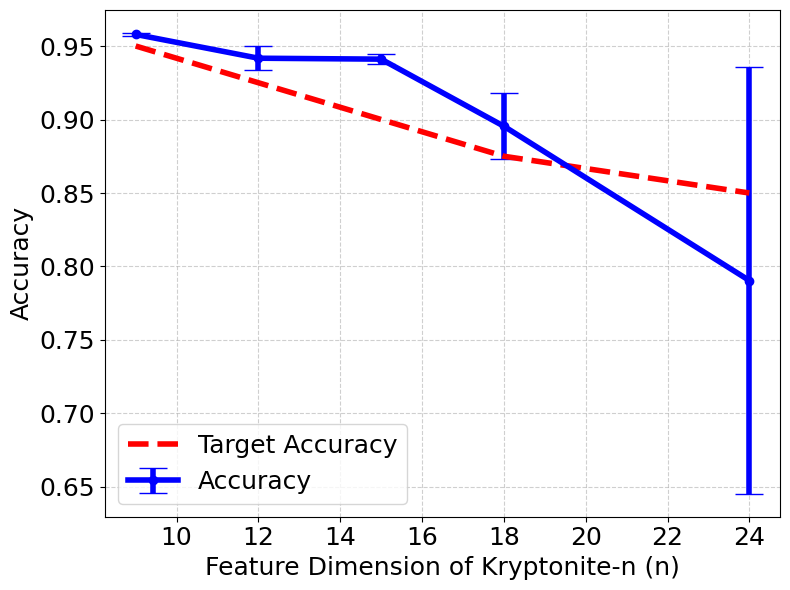

In [ ]:


n_values = np.array([9, 12, 15, 18, 24])
accuracies = np.empty((5))  
errors = np.empty((5))  



seed_accuracies = np.empty((5,5))
seed_accuracies[0] = np.array([0.9584, 0.9595, 0.9574, 0.9571, 0.9570])
seed_accuracies[1] = np.array([0.9324, 0.9457, 0.9484, 0.9315, 0.9505])
seed_accuracies[2] = np.array([0.9408, 0.9466, 0.9420, 0.9379, 0.9380])
seed_accuracies[3] = np.array([0.9058, 0.9289, 0.9012, 0.8724, 0.8688])
seed_accuracies[4] = np.array([0.8631, 0.8568, 0.8681, 0.5005, 0.8638])

for i,nx in enumerate(seed_accuracies):
    print(i)
    print(nx)
    accuracies[i] = np.mean(nx)
    errors[i] = np.std(nx)


target_n_values = np.array([9, 12, 15, 18, 24])
target_accuracies = np.array([0.95, 0.925, 0.90, 0.875, 0.85])


font = 18

plt.figure(figsize=(8, 6))

plt.errorbar(n_values, accuracies, yerr=errors, fmt='o-', label='Accuracy', capsize=10, color='blue', lw=4)

plt.plot(target_n_values, target_accuracies, 'r--', label='Target Accuracy', lw=4)

plt.title('', fontsize=font)
plt.xlabel('Feature Dimension of Kryptonite-n (n)', fontsize=font)
plt.ylabel('Accuracy', fontsize=font)
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)


plt.legend(fontsize=font)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


In [68]:
def hidden_nn(model, X_hidden):
    model.eval()
    with torch.no_grad():
        held_outputs = model(X_hidden.to(device))
        held_outputs = torch.round(torch.sigmoid(held_outputs)).cpu().numpy()
        
    return held_outputs

X_hidden = np.load('Datasets/hidden-kryptonite-%s-X.npy'%(n))
scaler.transform(X_hidden)
print(np.shape(X_hidden))
X_hidden = torch.tensor(X_hidden, dtype=torch.float32)
hidden_labels = hidden_nn(model, X_hidden)
print(np.shape(hidden_labels))
print(hidden_labels)


directory = "hiddenlabels/"
filename = f"y_predicted_{n}.npy"

os.makedirs(directory, exist_ok=True)

file_path = os.path.join(directory, filename)

np.save(file_path, hidden_labels)

print(f"Array saved to {file_path}")


(10000, 24)
(10000, 1)
[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
Array saved to hiddenlabels/y_predicted_24.npy


#### Grid Search Hyperparameter Tuning

In [69]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


In [70]:
def grid_search(X_train, y_train, X_val, y_val, param_grid, krypto_n):
    best_accuracy = 0
    best_params = None
    best_model = None
    
    for depth, hidden_size, learning_rate, batch_size, epochs in product(*param_grid.values()):


        print(f"Training with depth={depth}, hidden_size={hidden_size}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")
        
        model = NeuralNetwork(input_size=krypto_n, hidden_size=hidden_size, depth=depth).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


        g = torch.Generator()
        g.manual_seed(myseed)
        
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
        
        train_nn(model, train_loader, criterion, optimizer, epochs=epochs)
        
        accuracy = validate_nn(model, X_val, y_val)
        print(f"Validation Accuracy: {accuracy:.4f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'depth':depth, 'hidden_size': hidden_size, 'learning_rate': learning_rate, 
                           'batch_size': batch_size, 'epochs': epochs}
            best_model = model

        print(f"Current best accuracy: {best_accuracy:.4f}")

    
    print("Best Parameters:", best_params)
    print("Best Validation Accuracy:", best_accuracy)
    print(f"Krypto variant: {krypto_n}")
    
    
    return best_model, best_params

#### Random Grid Search

In [12]:
def rand_grid_search(X_train, y_train, X_val, y_val, krypto_n):
    best_accuracy = 0
    best_params = None
    best_model = None
    
    combos = 0
    max_combos = 10

    while best_accuracy < 0.90:


        # hidden_sizes = param_grid['hidden_size']
        # learning_rates = param_grid~learning_rate']
        # batch_sizes = param_grid['batch_size']
        # epoch_list = param_grid['epochs']

        hidden_size = np.random.randint(10,4000)
        learning_rate = np.random.uniform(0.0003, 0.0045)
        batch_size = np.random.randint(64,6000)
        epochs = np.random.randint(15, 50)
        depth = np.random.randint(2,3)



        print(f"Training with depth={depth}, hidden_size={hidden_size}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")
        
        model = NeuralNetwork(input_size=krypto_n, hidden_size=hidden_size, depth=depth).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        g = torch.Generator()
        g.manual_seed(myseed)
        
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
        
        train_nn(model, train_loader, criterion, optimizer, epochs=epochs)
        
        accuracy = validate_nn(model, X_val, y_val)
        print(f"Validation Accuracy: {accuracy:.4f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'depth': [depth], 'hidden_size': [hidden_size], 'learning_rate': [learning_rate], 
                           'batch_size': [batch_size], 'epochs': [epochs]}
            best_model = model

        print(f"Current best accuracy: {best_accuracy:.4f}")
        combos += 1


    print("Best Parameters:", best_params)
    print("Best Validation Accuracy:", best_accuracy)
    print(f"Krypto variant: {krypto_n}")
    print(combos)
    return best_model, best_params

### Bayesian Hyperparameter Tuning

In [ ]:



# tracker = EmissionsTracker()
# tracker.start()

param_space = [
    Real(1e-5, 1e-1, prior="log-uniform", name="learning_rate"), 
    Integer(100, 2000, prior = "log-uniform",name="hidden_size"),              
    Real(2,2.5, prior="log-uniform" ,name="depth"),                           
    Integer(2000, 30000, prior = "log-uniform", name="batch_size"),                   
    Integer(10, 180,prior = "log-uniform", name="epochs"),
    Real(0.0000001,0.1, prior ="log-uniform", name="decay")
]

# n=15 paramspace
# param_space = [
#     Real(1e-5, 1e-2, prior="log-uniform", name="learning_rate"),  
#     Integer(2, 6000, prior = "log-uniform",name="hidden_size"),                       
#     Integer(2, 4, name="depth"),                               
#     Integer(16, 10000, prior = "log-uniform", name="batch_size"),                         
#     Integer(1, 500, name="epochs"),                             
# ]

# best validation performance at around:
# lr = 0.0002
# hidden_size = 889-1200
# depth = 2
# batch_size = 40
# epochs = 500


set_seeds(myseed)

krypto_n = n
k_folds = 5

@use_named_args(param_space)

def objective(learning_rate, hidden_size, depth, batch_size, epochs, decay):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=myseed)
    fold_accuracies = []

    print(f"Training with hyperparameters:\n\nlearning rate={learning_rate}\nhidden size={hidden_size}\ndepth={np.floor(depth)}\nbatch_size={batch_size}\nepochs={epochs}\ndecay={decay}\n")
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        # fold_start = time.perf_counter()
        print(f"Fold {fold + 1}/{k_folds}")

        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        


        model = NeuralNetwork(input_size=krypto_n, hidden_size=hidden_size, depth=int(np.floor(depth))).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)
        
        train_dataset = TensorDataset(X_train_fold, y_train_fold)
        g = torch.Generator()
        g.manual_seed(myseed) 
        train_loader = DataLoader(train_dataset, batch_size=int(batch_size), shuffle=True, worker_init_fn=seed_worker, generator=g)
        
        epochs = train_nn(model, train_loader, criterion, optimizer, epochs=epochs, X_val =X_val_fold, y_val = y_val_fold)
        # epochs = train_nn(model, train_loader, criterion, optimizer, epochs=epochs)
       
       
        torch.cuda.empty_cache()


        print(f"\nTrained in {epochs} epochs\n")
        
        # fold_end = time.perf_counter()

        accuracy = validate_nn(model, X_val_fold, y_val_fold)
        print(f"Validation Accuracy for Fold {fold + 1}: {accuracy:.4f}")
        print(f"\nwith hyperparameters:\n\nlearning rate={learning_rate}\nhidden size={hidden_size}\ndepth={int(np.floor(depth))}\nbatch_size={batch_size}\nepochs={epochs}\ndecay={decay}\n\n\n")
        if accuracy < 0.74:
            return -accuracy
        
        # fold_duration = fold_end - fold_start
        # if fold_duration > 80:
            # return 1
        
        fold_accuracies.append(accuracy)
    
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Validation Accuracy: {avg_accuracy:.4f} for hyperparameters:\n\nlearning rate={learning_rate}\nhidden size={hidden_size}\ndepth={np.floor(depth)}\nbatch_size={batch_size}\nepochs={epochs}\ndecay={decay}\n\n\n")


    # min_accuracy = min(fold_accuracies)
    # print(f"Min Validation Accuracy: {min_accuracy:.4f} for hyperparameters:\n\nlearning rate={learning_rate}\nhidden size={hidden_size}\ndepth=2\nbatch_size={batch_size}\nepochs={epochs}\n\n\n")    

    return -avg_accuracy



result = gp_minimize(objective, param_space, n_calls=60, random_state=myseed)

plot_convergence(result)

best_params = result.x

# emissions: float = tracker.stop()
# print(emissions)



Training with hyperparameters:

learning rate=0.04003923969404982
hidden size=168
depth=2.0
batch_size=10407
epochs=56
decay=7.059680419915504e-07

Fold 1/5
Epoch 1/56, Loss: 1.1497
Epoch 2/56, Loss: 0.6945
Epoch 3/56, Loss: 0.6934
Epoch 4/56, Loss: 0.6932
Epoch 5/56, Loss: 0.6932
Epoch 6/56, Loss: 0.6932


KeyboardInterrupt: 

In [ ]:
set_seeds(myseed)

model = NeuralNetwork(input_size=krypto_n, hidden_size=best_params[1], depth=int(best_params[2])).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params[0], weight_decay=best_params[5])

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=int(best_params[3]), shuffle=True)



# train_nn(model, train_loader, criterion, optimizer, epochs=best_params[4])
train_nn(model, train_loader, criterion, optimizer, epochs=best_params[4], X_val = X_test, y_val=y_test)

test_accuracy = validate_nn(model, X_test, y_test)
print(f"Test Accuracy with Best Hyperparameters: {test_accuracy:.4f}")



# n=9
# seed = 6095
# 80/20
# Test Accuracy with Best Hyperparameters: 0.9551

# 70/30

# 90/10  



# seed = 42
# Test Accuracy with Best Hyperparameters: 0.9595

# seed = 81
# Test Accuracy with Best Hyperparameters: 0.9574

# seed = 180
# Test Accuracy with Best Hyperparameters: 0.9571

# seed = 4
# Test Accuracy with Best Hyperparameters: 0.9570


# n=12
# seed = 6095
# Test Accuracy with Best Hyperparameters: 0.9324

# seed = 42
# Test Accuracy with Best Hyperparameters: 0.9457

# seed = 81
# Test Accuracy with Best Hyperparameters: 0.9484

# seed = 180
# Test Accuracy with Best Hyperparameters: 0.9315

# seed = 4
# Test Accuracy with Best Hyperparameters: 0.9505



# n=18 Test Accuracy with Best Hyperparameters: 0.8527


# n=12
# Test Accuracy with Best Hyperparameters: 0.9356


# n=15 

# [0.0008212520954386176, np.int64(514), np.int64(2), np.int64(84), np.int64(500), 0.0006296438079895955]


# seed = 6095
# Test Accuracy with Best Hyperparameters: 0.9408

# seed = 42
# Test Accuracy with Best Hyperparameters: 0.9466

# seed = 81
# Test Accuracy with Best Hyperparameters: 0.9420

# seed = 180
# Test Accuracy with Best Hyperparameters: 0.9379

# seed = 4
# Test Accuracy with Best Hyperparameters: 0.9380




# n=18 

# [0.005000499108369632, np.int64(1000), 2.3181051861840816, np.int64(1778), np.int64(264), 0.00036096505804747496]

# seed = 6095
# Test Accuracy with Best Hyperparameters: 0.9058

# seed = 42

# seed = 81

# seed = 180

# seed = 4



# n=24
# Test Accuracy with Best Hyperparameters: 0.8631





Epoch 1/86, Loss: 0.8068
Epoch 2/86, Loss: 0.6932
Epoch 3/86, Loss: 0.6932
Epoch 4/86, Loss: 0.6932
Epoch 5/86, Loss: 0.6931


KeyboardInterrupt: 

In [ ]:
print(best_params)


[0.008349349990043525, np.int64(800), 2.7541886562632367, np.int64(2000), np.int64(86), 1e-05]
